# Transfer Learning et Fine-Tuning avec BERT : Classification

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer expliquer pas à pas le préprocessing effectué sur le dataset concerné et comparer les résultats des différentes stratégies appliquées parmi:

- Classification baseline avec LSTM
- Transfer Learning en NLP avec l'architecture BERT
- Fine-Tuning en NLP avec l'architecture BERT

## 1. Imports et Configuration

In [1]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML
import warnings
import re
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import pickle
import json
# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
# KerasNLP pour BERT
import keras_nlp
# Sklearn pour métriques
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\n TensorFlow version: {tf.__version__}")
print(f" Keras version: {keras.__version__}")
print(f" KerasNLP version: {keras_nlp.__version__}")
print(f" Backend: {keras.backend.backend()}")


2025-12-04 14:11:16.250358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764857476.275173   42600 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764857476.283225   42600 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764857476.302416   42600 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764857476.302440   42600 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764857476.302443   42600 computation_placer.cc:177] computation placer alr

  Aucun GPU détecté - Utilisation du CPU

 TensorFlow version: 2.19.1
 Keras version: 3.12.0
 KerasNLP version: 0.23.0
 Backend: tensorflow


2025-12-04 14:11:18.517969: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2025-12-04 14:11:18.518682: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-12-04 14:11:18.518694: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: cs-01kbmpkhkt8qrst9wjwm8w9jrz
2025-12-04 14:11:18.518710: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: cs-01kbmpkhkt8qrst9wjwm8w9jrz
2025-12-04 14:11:18.519130: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 535.274.2
2025-12-04 14:11:18.519164: I ext

#### Chargement du dataset et traitement des cellules manquantes

In [2]:
# Télécharger le dataset csv et l'afficher
print(" Chargement du dataset CSV...\n")

# Charger le CSV
df = pd.read_csv('data/dataset-for-training.csv')

print(f" Dataset chargé : {len(df)} lignes")
print(f"\nColonnes : {list(df.columns)}")
print(f"\n Aperçu des données :")
print(df.head())

# Nettoyer les données : supprimer les lignes avec des valeurs manquantes
print(f"\n Nettoyage des données...")
print(f"Lignes avec valeurs manquantes : {df.isnull().sum().sum()}")
df = df.dropna()

# Nettoyer les thématiques : supprimer les lignes avec thématiques vides ou invalides
df['Thématique'] = df['Thématique'].str.strip()  # Supprimer espaces
df = df[df['Thématique'].str.len() > 0]  # Supprimer thématiques vides
df = df[~df['Thématique'].str.match(r'^[\W_]+$')]  # Supprimer thématiques avec seulement des caractères spéciaux

print(f" Après nettoyage : {len(df)} lignes")

# Statistiques des thématiques
print(f"\n Distribution des thématiques :")
thematic_counts = df['Thématique'].value_counts()
print(thematic_counts)
print(f"\nNombre de thématiques uniques : {df['Thématique'].nunique()}")

 Chargement du dataset CSV...

 Dataset chargé : 5102 lignes

Colonnes : ["Titre de l'opération", 'Thématique']

 Aperçu des données :
                                Titre de l'opération             Thématique
0           Art urbain quartier des impressionnistes           Cadre de vie
1     Des bancs pour les écoles du boulevard Pereire  Education et jeunesse
2  Des lanternes pour le quartier historique du 2...           Cadre de vie
3  Cour de récréation école élémentaire La Motte ...  Education et jeunesse
4  Installer des espaces de convivialité aux Butt...           Cadre de vie

 Nettoyage des données...
Lignes avec valeurs manquantes : 5
 Après nettoyage : 5097 lignes

 Distribution des thématiques :
Thématique
Education et jeunesse     1404
Environnement              967
Cadre de vie               754
Solidarités                590
Culture et patrimoine      340
Sport                      334
Propreté                   308
Attractivité et emploi     141
Mobilités               

#### Nettoyage du corpus texte (colonne "Thématique")

In [3]:
# Nettoyage du texte français
def preprocess_text(text):
    """Normalisation du texte français"""
    text = text.lower()
    text = re.sub(r"[^a-zàâäæçéèêëïîôùûüÿœ'\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

print(" Nettoyage des titres de projets...\n")
# AVANT 
print(df['Titre de l\'opération'].head(20))
# Appliquer le preprocessing sur la colonne "Titre de l'opération"
df['Titre de l\'opération'] = df['Titre de l\'opération'].apply(preprocess_text)

# APRES
print(" Titres nettoyés !")
print(f"\n Exemples de titres nettoyés :")
print(df['Titre de l\'opération'].head(20))

 Nettoyage des titres de projets...

0              Art urbain quartier des impressionnistes
1        Des bancs pour les écoles du boulevard Pereire
2     Des lanternes pour le quartier historique du 2...
3     Cour de récréation école élémentaire La Motte ...
4     Installer des espaces de convivialité aux Butt...
5                        Continuité cyclable rue Riquet
6              Piétonnisation du quartier Saint-Séverin
7              Rénovation de la sous-dalle Beaugrenelle
8                    Remise en état horloge St Ambroise
9       Rénover les aménagements de la rue Jeanne-d’Arc
10                            Cultiver au Champ de Mars
11    Les Petits Maraîchers - potagers pédagogiques ...
12                                Fresque rue Broca 1/2
13                      Playground du jardin des Halles
14    Parcours végétal et artistique entre Montmartr...
15                Réfectoire école maternelle BESSIERES
16    Végétaliser les trottoirs du 15ème / 01- Gerbe...
17         

#### Encodage des labels et sauvegarde de la clé de traduction

In [ ]:
# Encoder les thématiques (string) en entiers AVANT la séparation
print(" Encodage des thématiques en entiers...\n")

# Créer l'encodeur
label_encoder = LabelEncoder()

# Fit sur TOUTES les thématiques du dataset
label_encoder.fit(df['Thématique'])

# Transformer toutes les thématiques
y_all_encoded = label_encoder.transform(df['Thématique'])

# Nombre de classes
num_classes = len(label_encoder.classes_)

print(f" Encodage terminé !")
print(f"\n Nombre de classes : {num_classes}")
print(f"\n  Mapping des thématiques (10 premières) :")
for idx, thematic in enumerate(label_encoder.classes_[:10]):
    print(f"   {idx} → {thematic}")

if num_classes > 10:
    print(f"   ... et {num_classes - 10} autres thématiques")

# Sauvegarder l'encodeur et le mapping pour la production
print(f"\n Sauvegarde du label encoder et du mapping...")

# Créer le mapping num → label et label → num
mapping_dict = {int(i): str(label) for i, label in enumerate(label_encoder.classes_)}
reverse_mapping = {str(label): int(i) for i, label in enumerate(label_encoder.classes_)}

# Sauvegarder en JSON (human-readable)
with open('model/lstm/label_mapping.json', 'w', encoding='utf-8') as f:
    json.dump({
        'num_to_label': mapping_dict,
        'label_to_num': reverse_mapping,
        'num_classes': num_classes
    }, f, ensure_ascii=False, indent=2)

print(f" Fichiers sauvegardés :")
print(f"   - model/lstm/label_mapping.json")
print(f"\n Exemple :")
print(f"   Thématique originale : '{df['Thématique'].iloc[0]}'")
print(f"   Thématique encodée   : {y_all_encoded[0]}")


 Encodage des thématiques en entiers...

 Encodage terminé !

 Nombre de classes : 11

  Mapping des thématiques (10 premières) :
   0 → Attractivité et emploi
   1 → Cadre de vie
   2 → Culture et patrimoine
   3 → Education et jeunesse
   4 → Environnement
   5 → Mobilités
   6 → Propreté
   7 → Prévention et sécurité
   8 → Santé
   9 → Solidarités
   ... et 1 autres thématiques

 Sauvegarde de l'encodeur et du mapping...
 Fichiers sauvegardés :
   - model/label_mapping.json

 Exemple :
   Thématique originale : 'Cadre de vie'
   Thématique encodée   : 1


#### Séparation des jeux de test/train/validation

In [5]:
print(f" Séparation des données...\n")

# Extraire X (textes) et y (thématiques ENCODÉES)
X_all = df['Titre de l\'opération'].values
y_all = y_all_encoded  # Utiliser les labels encodés

print(f"Nombre total de projets : {len(X_all)}")
print(f"Nombre de thématiques uniques : {num_classes}")

# Séparation 70% train / 30% test (stratifié pour garder la distribution des thématiques)
X_train_all_text, X_test_text, y_train_all, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=SEED, stratify=y_all
)

# Créer un validation set (20% du train)
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_all_text, y_train_all, test_size=0.2, random_state=SEED, stratify=y_train_all
)

print(f"\n Préparation terminée !")
print(f"\n Répartition finale:")
print(f"   Train: {len(X_train_text):,} projets ({len(X_train_text)/len(df)*100:.1f}%)")
print(f"   Validation: {len(X_val_text):,} projets ({len(X_val_text)/len(df)*100:.1f}%)")
print(f"   Test: {len(X_test_text):,} projets ({len(X_test_text)/len(df)*100:.1f}%)")

print(f"\n Exemple de projet :")
print(f"Titre : {X_train_text[0]}")
print(f"Thématique (encodée) : {y_train[0]}")
print(f"Thématique (décodée) : {label_encoder.inverse_transform([y_train[0]])[0]}")

# Statistiques de longueur (convertir en str pour éviter les erreurs)
train_lengths = [len(str(text).split()) for text in X_train_text]
print(f"\n Longueur moyenne des titres: {np.mean(train_lengths):.1f} mots")
print(f" Longueur min: {np.min(train_lengths)} mots")
print(f" Longueur max: {np.max(train_lengths)} mots")

 Séparation des données...

Nombre total de projets : 5097
Nombre de thématiques uniques : 11

 Préparation terminée !

 Répartition finale:
   Train: 2,853 projets (56.0%)
   Validation: 714 projets (14.0%)
   Test: 1,530 projets (30.0%)

 Exemple de projet :
Titre : auvent groupe scolaire ampere
Thématique (encodée) : 3
Thématique (décodée) : Education et jeunesse

 Longueur moyenne des titres: 6.9 mots
 Longueur min: 1 mots
 Longueur max: 46 mots


In [6]:
# Note : y_train, y_val et y_test sont déjà encodés (entiers)
# Pas besoin de transformation supplémentaire

print(" Les labels sont déjà encodés en entiers")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_val shape: {y_val.shape}")
print(f"   y_test shape: {y_test.shape}")
print(f"\n   Nombre de classes : {num_classes}")

 Les labels sont déjà encodés en entiers
   y_train shape: (2853,)
   y_val shape: (714,)
   y_test shape: (1530,)

   Nombre de classes : 11


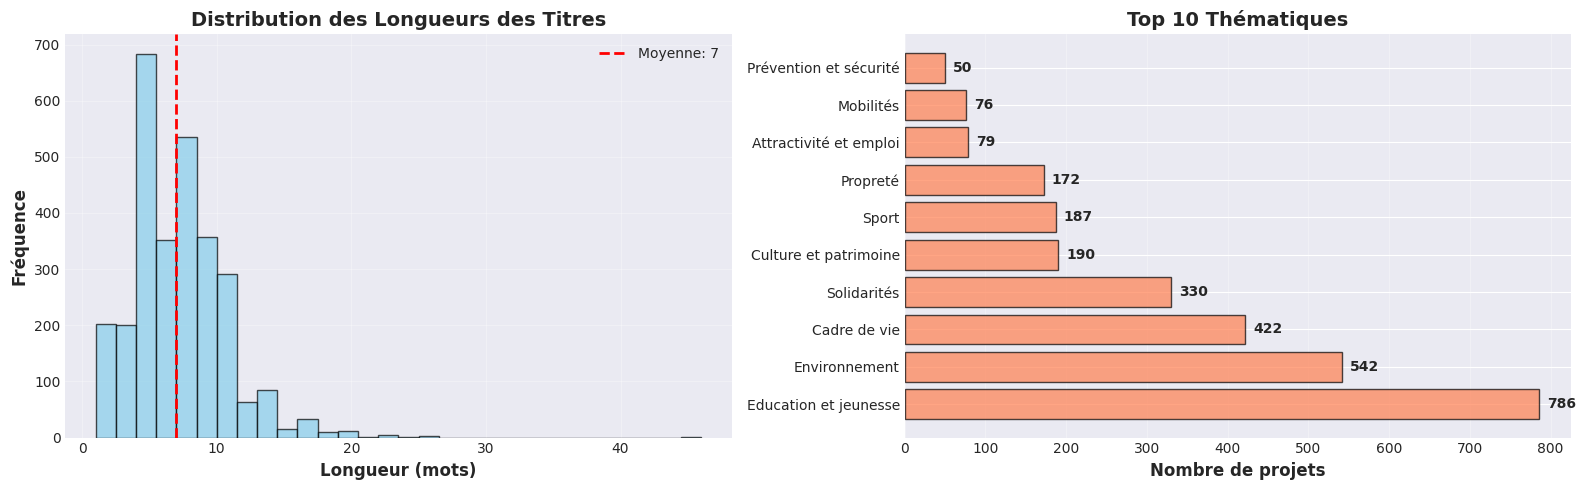


 Total de thématiques uniques: 11
 Thématique la plus fréquente: 'Education et jeunesse' (786 projets)


In [7]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Distribution des longueurs
ax1.hist(train_lengths, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(np.mean(train_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {np.mean(train_lengths):.0f}')
ax1.set_xlabel('Longueur (mots)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Longueurs des Titres', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Distribution des thématiques (décoder pour l'affichage)
y_train_decoded = label_encoder.inverse_transform(y_train)
thematic_counts = pd.Series(y_train_decoded).value_counts()
top_thematics = thematic_counts.head(10)  # Top 10 thématiques

ax2.barh(range(len(top_thematics)), top_thematics.values, color='coral', edgecolor='black', alpha=0.7)
ax2.set_yticks(range(len(top_thematics)))
ax2.set_yticklabels(top_thematics.index, fontsize=10)
ax2.set_xlabel('Nombre de projets', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Thématiques', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for i, count in enumerate(top_thematics.values):
    ax2.text(count + 10, i, f'{count}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Total de thématiques uniques: {len(thematic_counts)}")
print(f" Thématique la plus fréquente: '{top_thematics.index[0]}' ({top_thematics.values[0]} projets)")

### 2.1 Exemples de Projets

In [8]:
# Afficher des exemples de différentes thématiques
print("\n" + "=" * 80)
print(" " * 25 + " EXEMPLES DE PROJETS")
print("=" * 80)

# Prendre des exemples de différentes thématiques (décoder pour l'affichage)
y_train_decoded = label_encoder.inverse_transform(y_train)
unique_thematics = pd.Series(y_train_decoded).unique()[:11]  # 10 premières thématiques

for thematic in unique_thematics:
    indices = np.where(y_train_decoded == thematic)[0][:3]  # 3 exemples par thématique
    
    print(f"\n  Thématique: {thematic}")
    print("-" * 80)
    
    for idx in indices:
        titre = X_train_text[idx]
        print(f"  • {titre} ({len(titre.split())} mots)")
    
    print(f"  → Total: {len(np.where(y_train_decoded == thematic)[0])} projets dans cette thématique")


                          EXEMPLES DE PROJETS

  Thématique: Education et jeunesse
--------------------------------------------------------------------------------
  • auvent groupe scolaire ampere (4 mots)
  • rénovation de l'aire de jeux des jardins du trocadéro (9 mots)
  • collège george sand (3 mots)
  → Total: 786 projets dans cette thématique

  Thématique: Cadre de vie
--------------------------------------------------------------------------------
  • poursuivre la coulée verte à beaugrenelle de la rue caillavet à la rue du théatre (15 mots)
  • des tables de jeux d'échecs au parc monceau (8 mots)
  • des fontaines à boire dans tout paris fontaine arceau (9 mots)
  → Total: 422 projets dans cette thématique

  Thématique: Solidarités
--------------------------------------------------------------------------------
  • avenir (1 mots)
  • achat de vélos cargos et de matériel (7 mots)
  • aider les personnes fragiles à s'intégrer durablement (7 mots)
  → Total: 330 projets dans 

## 3. Modèle Baseline : LSTM

### 3.1 Tokenization pour LSTM

In [9]:
# Configuration
MAX_WORDS = 10000
MAX_LEN = 46

# Tokenizer
tokenizer_lstm = Tokenizer(num_words=MAX_WORDS, oov_token='<UNK>')
tokenizer_lstm.fit_on_texts(X_train_text)

# Séquences
X_train_seq = tokenizer_lstm.texts_to_sequences(X_train_text)
X_val_seq = tokenizer_lstm.texts_to_sequences(X_val_text)
X_test_seq = tokenizer_lstm.texts_to_sequences(X_test_text)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

print(f" Tokenization terminée !")
print(f"\n Shapes: Train {X_train_pad.shape}, Val {X_val_pad.shape}, Test {X_test_pad.shape}")

 Tokenization terminée !

 Shapes: Train (2853, 46), Val (714, 46), Test (1530, 46)


In [ ]:
# Sauvegarder le tokenizer LSTM pour utilisation en production
print(f"\n Sauvegarde du tokenizer LSTM...")

with open('model/lstm/tokenizer_lstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer_lstm, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f" Tokenizer sauvegardé : model/lstm/tokenizer_lstm.pickle")
print(f"   - Vocabulaire : {len(tokenizer_lstm.word_index)} mots")
print(f"   - MAX_WORDS : {MAX_WORDS}")
print(f"   - MAX_LEN : {MAX_LEN}")

### 3.2 Architecture et Entraînement LSTM

In [10]:
def creer_modele_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True)),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(lstm_units)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')  #  Utiliser num_classes au lieu de 1
    ])
    return model

lstm_model = creer_modele_lstm(MAX_WORDS)
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(" Modèle LSTM créé !\n")
lstm_model.summary()

 Modèle LSTM créé !



Model: "sequential"

 Layer (type)                     Output Shape                  Param # 

 embedding (Embedding)            ?                         0 (unbuilt) 

 bidirectional (Bidirectional)    ?                         0 (unbuilt) 

 dropout (Dropout)                ?                                   0 

 bidirectional_1 (Bidirectional)  ?                         0 (unbuilt) 

 dropout_1 (Dropout)              ?                                   0 

 dense (Dense)                    ?                         0 (unbuilt) 

 dropout_2 (Dropout)              ?                                   0 

 dense_1 (Dense)                  ?                         0 (unbuilt)

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Entraînement
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print(" Entraînement LSTM...\n")
history_lstm = lstm_model.fit(
    X_train_pad, y_train,  # y_train est déjà encodé
    validation_data=(X_val_pad, y_val),  # y_val est déjà encodé
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

print("\n Entraînement LSTM terminé !")

 Entraînement LSTM...

Epoch 1/10


45/45  9s 83ms/step - accuracy: 0.2443 - loss: 2.1344 - val_accuracy: 0.3137 - val_loss: 1.9771
Epoch 2/10
45/45  3s 67ms/step - accuracy: 0.3940 - loss: 1.7728 - val_accuracy: 0.5252 - val_loss: 1.4431
Epoch 3/10
45/45  3s 69ms/step - accuracy: 0.5790 - loss: 1.2668 - val_accuracy: 0.5868 - val_loss: 1.2690
Epoch 4/10
45/45  3s 65ms/step - accuracy: 0.6744 - loss: 0.9988 - val_accuracy: 0.6092 - val_loss: 1.1977
Epoch 5/10
45/45  3s 66ms/step - accuracy: 0.7392 - loss: 0.8174 - val_accuracy: 0.6331 - val_loss: 1.2144
Epoch 6/10
45/45  3s 71ms/step - accuracy: 0.8209 - loss: 0.6046 - val_accuracy: 0.6359 - val_loss: 1.3344
Epoch 7/10
45/45  3s 66ms/step - accuracy: 0.8549 - loss: 0.4832 - val_accuracy: 0.6317 - val_loss: 1.4853

 Entraînement LSTM terminé !


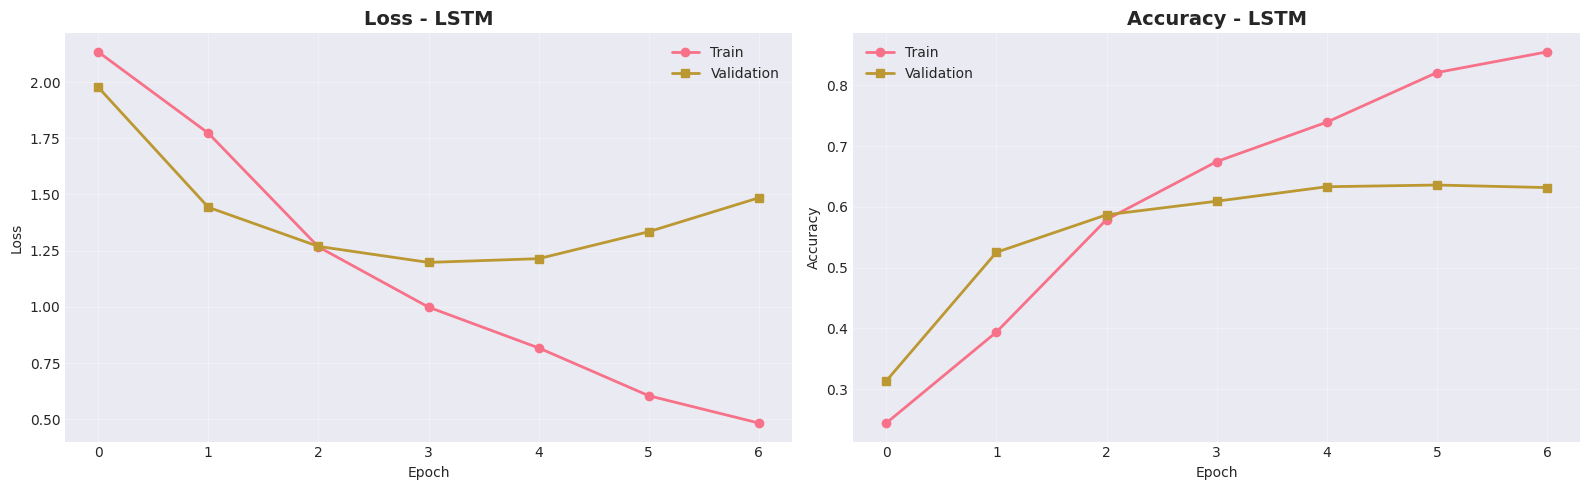

In [12]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(history_lstm.history['loss'], label='Train', linewidth=2, marker='o')
ax1.plot(history_lstm.history['val_loss'], label='Validation', linewidth=2, marker='s')
ax1.set_title('Loss - LSTM', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history_lstm.history['accuracy'], label='Train', linewidth=2, marker='o')
ax2.plot(history_lstm.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
ax2.set_title('Accuracy - LSTM', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Évaluation LSTM

In [13]:
# Évaluation
test_loss, test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad, verbose=0), axis=1)

print("\n PERFORMANCES LSTM")
print("=" * 60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("\n Classification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=label_encoder.classes_))


 PERFORMANCES LSTM
Test Loss: 1.2443
Test Accuracy: 0.5935 (59.35%)

 Classification Report:
                        precision    recall  f1-score   support

Attractivité et emploi       0.00      0.00      0.00        42
          Cadre de vie       0.37      0.77      0.50       226
 Culture et patrimoine       0.00      0.00      0.00       102
 Education et jeunesse       0.92      0.83      0.87       422
         Environnement       0.81      0.66      0.73       290
             Mobilités       0.00      0.00      0.00        41
              Propreté       0.98      0.60      0.75        93
Prévention et sécurité       0.00      0.00      0.00        26
                 Santé       0.00      0.00      0.00        11
           Solidarités       0.38      0.68      0.49       177
                 Sport       0.25      0.14      0.18       100

              accuracy                           0.59      1530
             macro avg       0.34      0.34      0.32      1530
        

## 4. BERT avec KerasNLP

### 4.1 Introduction à KerasNLP

**KerasNLP** est la bibliothèque officielle de Keras pour le NLP :
-  Nativement compatible avec Keras 3
-  API simple et cohérente
-  Preprocessing intégré
-  Modèles pré-entraînés (BERT, GPT, etc.)
-  Optimisé pour les performances

### 4.2 Préparation des Données pour BERT

In [14]:
# Charger le préprocesseur BERT de KerasNLP
print(" Chargement du preprocesseur BERT...\n")

# Utiliser le preprocesseur BERT pré-entraîné
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_small_en_uncased",  # Version légère pour la démo
    sequence_length=128
)

print(" Preprocesseur chargé !")
print(f"\nVocabulaire: {preprocessor.tokenizer.vocabulary_size():,} tokens")
print(f"Longueur de séquence: 128")

 Chargement du preprocesseur BERT...

 Preprocesseur chargé !

Vocabulaire: 30,522 tokens
Longueur de séquence: 128


In [15]:
# Test du preprocesseur
test_text = "This movie was absolutely fantastic!"
preprocessed = preprocessor([test_text])

print(f"\n Test du preprocesseur:")
print(f"\nTexte original: '{test_text}'")
print(f"\nClés disponibles: {list(preprocessed.keys())}")
print(f"\ntoken_ids shape: {preprocessed['token_ids'].shape}")
print(f"segment_ids shape: {preprocessed['segment_ids'].shape}")
print(f"padding_mask shape: {preprocessed['padding_mask'].shape}")


 Test du preprocesseur:

Texte original: 'This movie was absolutely fantastic!'

Clés disponibles: ['token_ids', 'padding_mask', 'segment_ids']

token_ids shape: (1, 128)
segment_ids shape: (1, 128)
padding_mask shape: (1, 128)


## 5. Fine-Tuning BERT

### 5.1 Approche 1 : Feature Extraction (BERT Gelé)

In [16]:
def creer_modele_bert_frozen():
    """
    Crée un modèle BERT avec les poids gelés (Feature Extraction).
    """
    # Charger BERT pré-entraîné
    bert_backbone = keras_nlp.models.BertBackbone.from_preset(
        "bert_small_en_uncased",  # Version légère
        trainable=False  # GELÉ
    )
    
    # Input
    inputs = {
        "token_ids": layers.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
        "segment_ids": layers.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
        "padding_mask": layers.Input(shape=(128,), dtype=tf.int32, name="padding_mask"),
    }
    
    # BERT Encoder
    bert_output = bert_backbone(inputs)["sequence_output"]
    
    # Prendre le [CLS] token (première position)
    cls_token = bert_output[:, 0, :]
    
    # Couches de classification
    x = layers.Dropout(0.3)(cls_token)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax', name='classifier')(x)
    
    model = keras.Model(inputs, output)
    
    return model, bert_backbone

# Créer le modèle
print(" Création du modèle BERT (Feature Extraction)...\n")
bert_frozen_model, bert_backbone = creer_modele_bert_frozen()

# Compiler
bert_frozen_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(" Modèle BERT (frozen) créé !\n")
bert_frozen_model.summary()


 Création du modèle BERT (Feature Extraction)...



 Modèle BERT (frozen) créé !



Model: "functional_1"

 Layer (type)         Output Shape          Param #  Connected to      

 padding_mask         (None, 128)                 0  -                 
 (InputLayer)                                                          

 segment_ids          (None, 128)                 0  -                 
 (InputLayer)                                                          

 token_ids            (None, 128)                 0  -                 
 (InputLayer)                                                          

 bert_backbone        [(None, 512),      28,763,648  padding_mask[0][… 
 (BertBackbone)       (None, 128, 512)]              segment_ids[0][0… 
                                                     token_ids[0][0]   

 get_item_1           (None, 512)                 0  bert_backbone[0]… 
 (GetItem)                                                             

 dropout_7 (Dropout)  (None, 512)                 0  get_item_1[0][0]  

 dense_2 (Dense)      (None, 64)             32,832  dropout_7[0][0]   

 dropout_8 (Dropout)  (None, 64)                  0  dense_2[0][0]     

 classifier (Dense)   (None, 11)                715  dropout_8[0][0]

 Total params: 28,797,195 (109.85 MB)

 Trainable params: 33,547 (131.04 KB)

 Non-trainable params: 28,763,648 (109.72 MB)

In [17]:
# Préprocesser les données
print(" Preprocessing des données avec BERT...\n")

X_train_bert = preprocessor(X_train_text)
X_val_bert = preprocessor(X_val_text)
X_test_bert = preprocessor(X_test_text)

print(" Preprocessing terminé !")

 Preprocessing des données avec BERT...

 Preprocessing terminé !


In [18]:
# Entraînement
print("\n Entraînement BERT (Feature Extraction)...\n")

history_bert_frozen = bert_frozen_model.fit(
    X_train_bert,
    y_train,
    validation_data=(X_val_bert, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

print("\n Entraînement BERT (frozen) terminé !")


 Entraînement BERT (Feature Extraction)...

Epoch 1/10


90/90  94s 999ms/step - accuracy: 0.2545 - loss: 2.1993 - val_accuracy: 0.3796 - val_loss: 1.8719
Epoch 2/10
90/90  88s 981ms/step - accuracy: 0.3309 - loss: 1.9215 - val_accuracy: 0.4020 - val_loss: 1.7666
Epoch 3/10
90/90  88s 980ms/step - accuracy: 0.3488 - loss: 1.8621 - val_accuracy: 0.4160 - val_loss: 1.6971
Epoch 4/10
90/90  88s 975ms/step - accuracy: 0.3863 - loss: 1.7842 - val_accuracy: 0.4398 - val_loss: 1.6529
Epoch 5/10
90/90  87s 968ms/step - accuracy: 0.4034 - loss: 1.7314 - val_accuracy: 0.4524 - val_loss: 1.6101
Epoch 6/10
90/90  86s 961ms/step - accuracy: 0.4185 - loss: 1.7140 - val_accuracy: 0.4426 - val_loss: 1.5786
Epoch 7/10
90/90  86s 963ms/step - accuracy: 0.4129 - loss: 1.6976 - val_accuracy: 0.4636 - val_loss: 1.5630
Epoch 8/10
90/90  87s 971ms/step - accuracy: 0.4255 - loss: 1.6529 - val_accuracy: 0.4664 - val_loss: 1.5547
Epoch 9/10
90/90  92s 1s/step - accuracy: 0.4294 - loss: 1.6234 - val_accuracy: 0.4762 - val_loss: 1.5263
Epoch 10/10
90/90  87s 967ms/step

### 5.2 Approche 2 : Fine-Tuning Complet

In [19]:
def creer_modele_bert_finetuned():
    """
    Crée un modèle BERT avec fine-tuning complet.
    """
    # BERT backbone - TOUS LES POIDS ENTRAÎNABLES
    bert_backbone = keras_nlp.models.BertBackbone.from_preset(
        "bert_tiny_en_uncased",
        trainable=True  # FINE-TUNING
    )
    
    # Inputs
    inputs = {
        "token_ids": layers.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
        "segment_ids": layers.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
        "padding_mask": layers.Input(shape=(128,), dtype=tf.int32, name="padding_mask"),
    }
    
    # BERT
    bert_output = bert_backbone(inputs)["sequence_output"]
    cls_token = bert_output[:, 0, :]
    
    # Classification
    x = layers.Dropout(0.3)(cls_token)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, output)
    
    return model

# Créer le modèle
print(" Création du modèle BERT (Fine-Tuning)...\n")
bert_finetuned_model = creer_modele_bert_finetuned()

# Compiler avec LR très bas
bert_finetuned_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(" Modèle BERT (fine-tuning) créé !")


 Création du modèle BERT (Fine-Tuning)...

 Modèle BERT (fine-tuning) créé !


In [20]:
# Callbacks
early_stop_bert = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7)

# Entraînement
print("\n Fine-Tuning BERT...\n")

history_bert_finetuned = bert_finetuned_model.fit(
    X_train_bert,
    y_train,
    validation_data=(X_val_bert, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop_bert, reduce_lr],
    verbose=1
)

print("\n Fine-Tuning BERT terminé !")


 Fine-Tuning BERT...

Epoch 1/10


90/90  25s 202ms/step - accuracy: 0.1409 - loss: 2.7905 - val_accuracy: 0.2353 - val_loss: 2.1023 - learning_rate: 2.0000e-05
Epoch 2/10
90/90  18s 196ms/step - accuracy: 0.2012 - loss: 2.4288 - val_accuracy: 0.2871 - val_loss: 2.0419 - learning_rate: 2.0000e-05
Epoch 3/10
90/90  18s 197ms/step - accuracy: 0.2191 - loss: 2.3149 - val_accuracy: 0.3221 - val_loss: 2.0072 - learning_rate: 2.0000e-05
Epoch 4/10
90/90  18s 195ms/step - accuracy: 0.2478 - loss: 2.2175 - val_accuracy: 0.3207 - val_loss: 1.9870 - learning_rate: 2.0000e-05
Epoch 5/10
90/90  17s 194ms/step - accuracy: 0.2517 - loss: 2.1717 - val_accuracy: 0.3333 - val_loss: 1.9735 - learning_rate: 2.0000e-05
Epoch 6/10
90/90  18s 195ms/step - accuracy: 0.2653 - loss: 2.1240 - val_accuracy: 0.3571 - val_loss: 1.9469 - learning_rate: 2.0000e-05
Epoch 7/10
90/90  18s 200ms/step - accuracy: 0.2769 - loss: 2.1155 - val_accuracy: 0.3838 - val_loss: 1.9183 - learning_rate: 2.0000e-05
Epoch 8/10
90/90  17s 191ms/step - accuracy: 0.2997 

## 6. Comparaison des Modèles

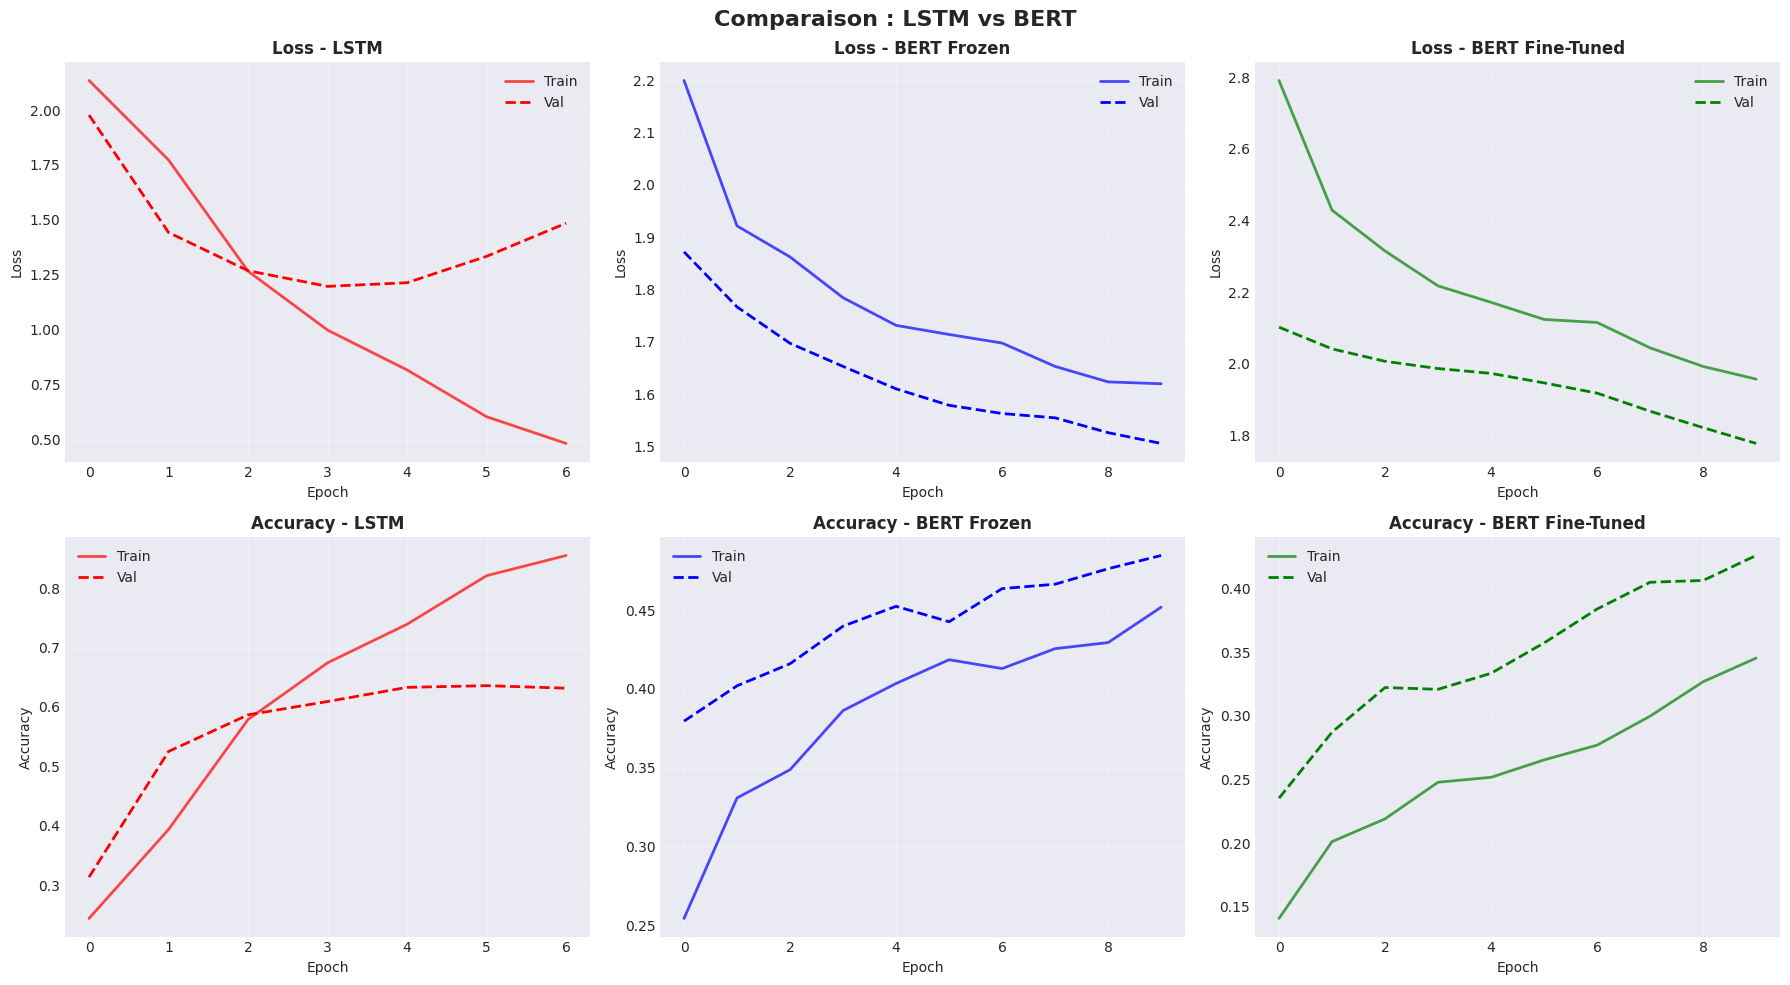

In [21]:
# Visualisation comparative
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison : LSTM vs BERT', fontsize=16, fontweight='bold')

models_histories = [
    ('LSTM', history_lstm, 'red'),
    ('BERT Frozen', history_bert_frozen, 'blue'),
    ('BERT Fine-Tuned', history_bert_finetuned, 'green')
]

# Loss
for idx, (name, history, color) in enumerate(models_histories):
    ax = axes[0, idx]
    ax.plot(history.history['loss'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_loss'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Loss - {name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(alpha=0.3)

# Accuracy
for idx, (name, history, color) in enumerate(models_histories):
    ax = axes[1, idx]
    ax.plot(history.history['accuracy'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_accuracy'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Accuracy - {name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.1 Évaluation Finale

In [22]:
# Évaluer tous les modèles
print("\n" + "=" * 80)
print(" " * 20 + " PERFORMANCES FINALES")
print("=" * 80)

# LSTM
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad, verbose=0), axis=1)

# BERT Frozen
bert_frozen_test_loss, bert_frozen_test_acc = bert_frozen_model.evaluate(X_test_bert, y_test, verbose=0)
y_pred_bert_frozen = np.argmax(bert_frozen_model.predict(X_test_bert, verbose=0), axis=1)

# BERT Fine-Tuned
bert_ft_test_loss, bert_ft_test_acc = bert_finetuned_model.evaluate(X_test_bert, y_test, verbose=0)
y_pred_bert_ft = np.argmax(bert_finetuned_model.predict(X_test_bert, verbose=0), axis=1)

# Tableau comparatif
results_df = pd.DataFrame({
    'Modèle': ['LSTM', 'BERT Frozen', 'BERT Fine-Tuned'],
    'Test Loss': [lstm_test_loss, bert_frozen_test_loss, bert_ft_test_loss],
    'Test Accuracy': [lstm_test_acc, bert_frozen_test_acc, bert_ft_test_acc],
    'Amélioration vs LSTM': [
        '0.00%',
        f'+{(bert_frozen_test_acc - lstm_test_acc)*100:.2f}%',
        f'+{(bert_ft_test_acc - lstm_test_acc)*100:.2f}%'
    ]
})

print("\n")
print(results_df.to_string(index=False))
print("\n" + "=" * 80)

best_idx = results_df['Test Accuracy'].idxmax()
print(f"\n MEILLEUR: {results_df.loc[best_idx, 'Modèle']} - {results_df.loc[best_idx, 'Test Accuracy']*100:.2f}%")



                     PERFORMANCES FINALES




         Modèle  Test Loss  Test Accuracy Amélioration vs LSTM
           LSTM   1.244263       0.593464                0.00%
    BERT Frozen   1.496337       0.481046             +-11.24%
BERT Fine-Tuned   1.721269       0.438562             +-15.49%


 MEILLEUR: LSTM - 59.35%


### 6.2 Matrices de Confusion

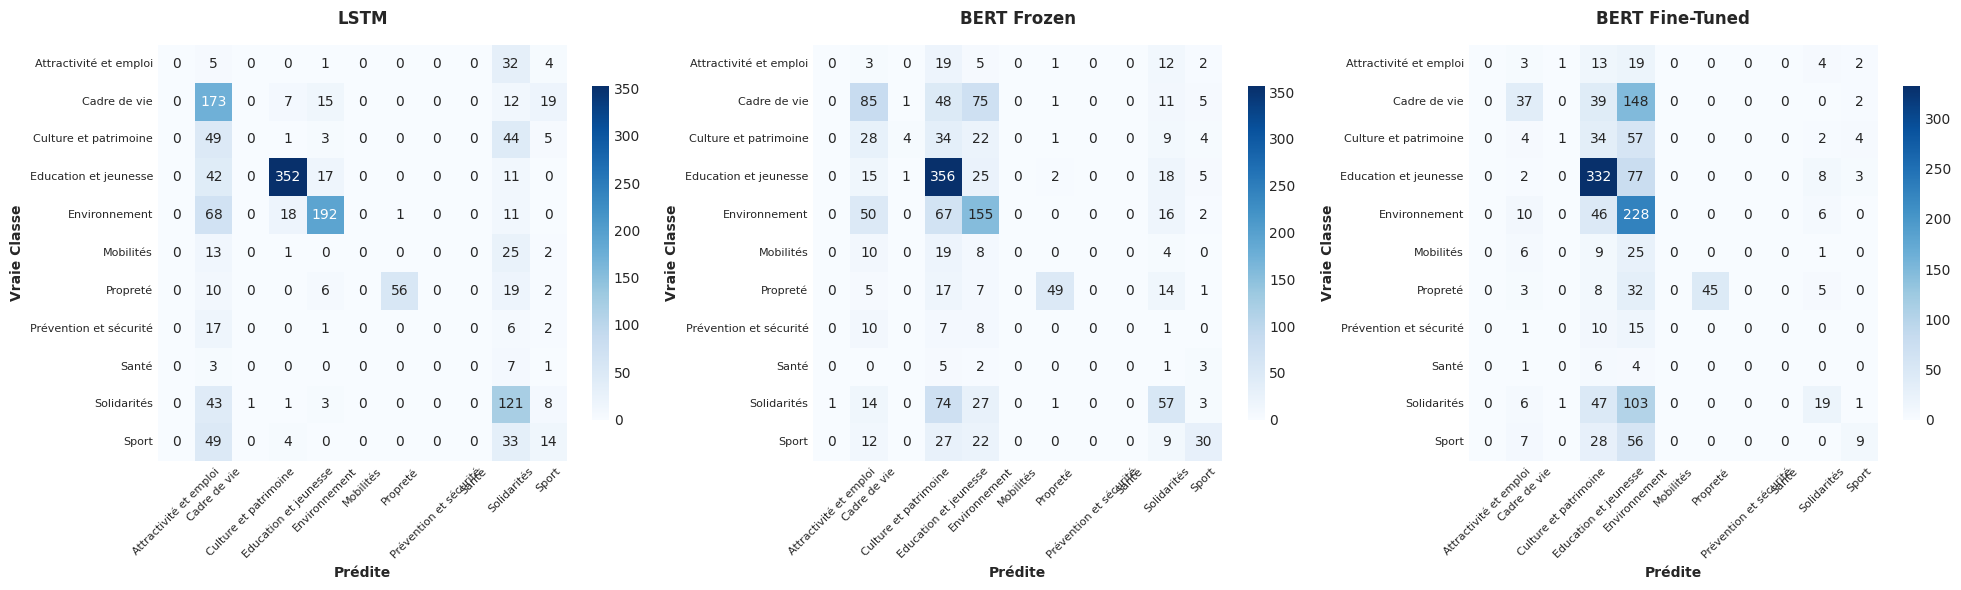

In [23]:
# Matrices de confusion
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

predictions = [
    ('LSTM', y_pred_lstm),
    ('BERT Frozen', y_pred_bert_frozen),
    ('BERT Fine-Tuned', y_pred_bert_ft)
]

for idx, (name, y_pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'shrink': 0.8})
    
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold', pad=15)
    axes[idx].set_ylabel('Vraie Classe', fontweight='bold')
    axes[idx].set_xlabel('Prédite', fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    axes[idx].tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.show()


In [24]:
# Reports détaillés
print("\n CLASSIFICATION REPORTS\n")
for name, y_pred in predictions:
    print(f"\n{name}:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



 CLASSIFICATION REPORTS


LSTM:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

Attractivité et emploi       0.00      0.00      0.00        42
          Cadre de vie       0.37      0.77      0.50       226
 Culture et patrimoine       0.00      0.00      0.00       102
 Education et jeunesse       0.92      0.83      0.87       422
         Environnement       0.81      0.66      0.73       290
             Mobilités       0.00      0.00      0.00        41
              Propreté       0.98      0.60      0.75        93
Prévention et sécurité       0.00      0.00      0.00        26
                 Santé       0.00      0.00      0.00        11
           Solidarités       0.38      0.68      0.49       177
                 Sport       0.25      0.14      0.18       100

              accuracy                           0.59      1530
             macro avg       0.34      0.34      0.3

## 7. Tests sur Nouvelles Reviews

In [25]:
# Titres de test (en français pour correspondre au dataset)
test_titles = [
    "alimentation biologique à la cantine ",
    "installation de panneaux solaires sur les bâtiments publics",
    "rénovation de la bibliothèque municipale",
    "organisation d'ateliers culturels pour les jeunes",
    "aménagement d'une piste cyclable sécurisée",
    "développement d'un jardin partagé communautaire",
]

print("\n" + "=" * 90)
print(" " * 20 + " PRÉDICTIONS LSTM SUR NOUVEAUX TITRES DE PROJETS")
print("=" * 90)

# Tokenizer les titres avec le tokenizer LSTM
test_seq = tokenizer_lstm.texts_to_sequences(test_titles)
test_pad = pad_sequences(test_seq, maxlen=MAX_LEN, padding='post')

# Prédire avec le modèle LSTM
predictions_proba = lstm_model.predict(test_pad, verbose=0)
predictions_classes = np.argmax(predictions_proba, axis=1)

for i, (title, class_idx, proba) in enumerate(zip(test_titles, predictions_classes, predictions_proba), 1):
    thematic = label_encoder.inverse_transform([class_idx])[0]
    confidence = proba[class_idx] * 100
    
    print(f"\n{i}. \"{title}\"")
    print(f"    Thématique prédite: {thematic}")
    print(f"    Confiance: {confidence:.1f}%")
    
    # Afficher les 3 prédictions les plus probables
    top3_indices = np.argsort(proba)[-3:][::-1]
    print(f"    Top 3 prédictions:")
    for idx in top3_indices:
        print(f"      - {label_encoder.inverse_transform([idx])[0]}: {proba[idx]*100:.1f}%")
    print("-" * 90)


                     PRÉDICTIONS LSTM SUR NOUVEAUX TITRES DE PROJETS

1. "alimentation biologique à la cantine "
    Thématique prédite: Solidarités
    Confiance: 28.4%
    Top 3 prédictions:
      - Solidarités: 28.4%
      - Sport: 20.9%
      - Culture et patrimoine: 13.3%
------------------------------------------------------------------------------------------

2. "installation de panneaux solaires sur les bâtiments publics"
    Thématique prédite: Environnement
    Confiance: 99.0%
    Top 3 prédictions:
      - Environnement: 99.0%
      - Cadre de vie: 0.5%
      - Culture et patrimoine: 0.2%
------------------------------------------------------------------------------------------

3. "rénovation de la bibliothèque municipale"
    Thématique prédite: Cadre de vie
    Confiance: 46.6%
    Top 3 prédictions:
      - Cadre de vie: 46.6%
      - Culture et patrimoine: 14.8%
      - Sport: 8.8%
--------------------------------------------------------------------------------------

# SAUVEGARDE DU MODELE LSTM

In [ ]:
# ici 
import os

print(" Sauvegarde du modèle LSTM...\n")

# Sauvegarder au format Keras (.keras)
model_path = 'model/lstm/lstm-budgets-participatif.keras'
lstm_model.save(model_path)

print(f" Modèle sauvegardé : {model_path}")
print(f"   Taille du fichier : {os.path.getsize(model_path) / (1024**2):.1f} MB")

# Sauvegarder aussi au format h5 (legacy)
model_h5_path = 'model/lstm/lstm-budgets-participatif.h5'
lstm_model.save(model_h5_path)
print(f"\n Modèle également sauvegardé en .h5 : {model_h5_path}")

 Sauvegarde du modèle LSTM...



 Modèle sauvegardé : lstm-budgets-participatif.keras
   Taille du fichier : 17.1 MB

 Modèle également sauvegardé en .h5 : lstm-budgets-participatif.h5


# CHARGEMENT du model saved

In [ ]:
# LA 
print(" Chargement du modèle sauvegardé...\n")

# Charger le modèle
loaded_lstm_model = keras.models.load_model(model_path)

print(" Modèle chargé avec succès !\n")

# Vérifier que le modèle chargé donne les mêmes prédictions
print(" Vérification de l'intégrité...")

# Prendre des exemples de test
test_sample = X_test_pad[:5]  # Prendre 5 exemples
test_texts = X_test_text[:5]  # Textes correspondants
test_labels = y_test[:5]  # Vraies étiquettes

# Prédictions avec le modèle original
pred_original = lstm_model.predict(test_sample, verbose=0)
pred_original_classes = np.argmax(pred_original, axis=1)

# Prédictions avec le modèle chargé
pred_loaded = loaded_lstm_model.predict(test_sample, verbose=0)
pred_loaded_classes = np.argmax(pred_loaded, axis=1)

# Affichage détaillé avec les thématiques
print("\n" + "=" * 90)
print(" " * 25 + " COMPARAISON DES PRÉDICTIONS")
print("=" * 90)

for i, (text, true_label, orig_pred, loaded_pred) in enumerate(
    zip(test_texts, test_labels, pred_original_classes, pred_loaded_classes), 1
):
    true_thematic = label_encoder.inverse_transform([true_label])[0]
    orig_thematic = label_encoder.inverse_transform([orig_pred])[0]
    loaded_thematic = label_encoder.inverse_transform([loaded_pred])[0]
    
    print(f"\n{i}. Titre: \"{text}\"")
    print(f"    Vraie thématique: {true_thematic}")
    print(f"    Modèle original: {orig_thematic} (confiance: {pred_original[i-1][orig_pred]*100:.1f}%)")
    print(f"   🟢 Modèle chargé: {loaded_thematic} (confiance: {pred_loaded[i-1][loaded_pred]*100:.1f}%)")
    
    if orig_pred == loaded_pred:
        print(f"    Prédictions identiques!")
    else:
        print(f"     Prédictions différentes!")

print("\n" + "=" * 90)

# Vérification numérique
if np.allclose(pred_original, pred_loaded, rtol=1e-5):
    print("\n Les prédictions numériques sont identiques - Le modèle a été correctement sauvegardé et chargé !")
else:
    print("\n  Différence détectée dans les prédictions numériques.")
    
# Comparaison détaillée
diff = np.abs(pred_original - pred_loaded)
print(f"\n Différence maximale : {diff.max():.2e}")
print(f"   Différence moyenne  : {diff.mean():.2e}")



 Chargement du modèle sauvegardé...

 Modèle chargé avec succès !

 Vérification de l'intégrité...



                          COMPARAISON DES PRÉDICTIONS

1. Titre: "bandes pododactiles quartier moutonduvernetun quartier plus accueillant pour les aveugles et malvoyants"
    Vraie thématique: Mobilités
    Modèle original: Solidarités (confiance: 22.9%)
   🟢 Modèle chargé: Solidarités (confiance: 22.9%)
    Prédictions identiques!

2. Titre: "food truck pédagogique écologique solidaire et participatif"
    Vraie thématique: Solidarités
    Modèle original: Solidarités (confiance: 40.7%)
   🟢 Modèle chargé: Solidarités (confiance: 40.7%)
    Prédictions identiques!

3. Titre: "la table solidaire"
    Vraie thématique: Solidarités
    Modèle original: Solidarités (confiance: 52.3%)
   🟢 Modèle chargé: Solidarités (confiance: 52.3%)
    Prédictions identiques!

4. Titre: "ruisseau mat"
    Vraie thématique: Education et jeunesse
    Modèle original: Education et jeunesse (confiance: 41.0%)
   🟢 Modèle chargé: Education et jeunesse (confiance: 41.0%)
    Prédictions identiques!

5. Titre

## 10. Ressources et Prochaines Étapes

## Conclusion

### Récapitulatif

Dans ce notebook, nous avons exploré :

1.  **Transfer Learning** avec BERT ENG
2.  **KerasNLP** : Solution officielle Keras 3
3.  **Feature Extraction** vs **Fine-Tuning**
4.  **Comparaisons** LSTM vs BERT
5.  **API Simple** et unifiée

### Points Clés

- **KerasNLP** est nativement compatible avec Keras 3
- API simple : `from_preset()` pour tout
- Preprocessing automatique intégré
- BERT surpasse LSTM grâce au pré-entraînement

### Message Final